# MSDS 7337 Final Project - Topic Modeling

Author: Nathan Wall

Date: 8/13/2019

This notebook contains the code and visualizations for the topic modeling of sample of reviews from IMDB from the crime genre

Notebook Sections:
- [Data Preperation](#prep)
- [Topic Modeling](#topicModel)
- [Interpreting Results](#results)

In [178]:
import random 
random.seed(13)
import re
import json
import pandas as pd
import numpy as np

#text pre-processing
import spacy
!python -m spacy download en_core_web_sm

#topic modeling
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from sklearn.decomposition import NMF

#visualizing results
import pyLDAvis.gensim
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


#hide depreciation warnings
import warnings
warnings.filterwarnings('ignore')  # To ignore all warnings that arise here to enhance clarity

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


## Preparing the reviews
<a id='prep'></a>

Open & read the text file

In [2]:
with open('msds7337_nwall_reviews.json', 'r') as json_file:
    data = json.load(json_file)

reviews = json.loads(data)
len(reviews)

1219

Generate the corpus from the reviews

In [3]:
corpus = [r['reviewText'] for r in reviews]
len(corpus)

1219

Before generating document word matrix let's apply some pre-processing to our data. Below we utilize spacy pre-processing pipeline to tokenize our reviews, but also apply some POS tagging & Named entity recognition to give us more flexibility in how we want to look at our data. Below is an example for a single review.

In [4]:
corpus[1]

"A nice easy breezy murder mystery. Full of fun. Don't count on anything serious or deep here just sit back with your popcorn and a soda and enjoy the movie. Nothing offencive here. Just an adult murder mystery romp. We don't get many like these anymore. Ignore the people who like to criticize everything because they think they are actual critics. Chemistry between Aniston and Sadler is awesome. I hope they make more movies together."

No lets remove all the stop words, punctuation, pronouns, & named entities to get a much more generalized review. To do this we created our own function to apply to a single text.

In [148]:
#load default pipeline
nlp = spacy.load("en_core_web_sm")

def preprocess_review(text, remove_ne = True):
    """ This function takes a document and applies some of preprocessing step

    :param text: A string, the single document you want to process.
    :param remove_ne: A boolean , whether you remove named entities from the text
    
    returns: A string with all tokens lemmatized & lower case with stop words, pronouns, and punctuation removed
    """
    doc = nlp(text)
    if remove_ne == True:
        named_entity = [i.text for i in doc.ents] #create list of named entities
        tokens = [token.lemma_.lower() for token in doc #take the lower case lemmatized word
                  if token.lemma_ != "-PRON-" #remove pronouns
                  and token.pos_ != "PROPN" #remove propernouns
                  and token.is_punct == False #remove punctiuation
                  and token.is_stop == False #remove stopwords
                  and token.is_digit == False #remove numbers
                  and token.is_space == False #remove space
                  and token.text not in named_entity #remove named entities
                 ]
    else:
        tokens = [token.lemma_.lower() for token in doc #take the lower case lemmatized word
                  if token.lemma_ != "-PRON-" #remove pronouns
                  and token.pos_ != "PROPN" #remove propernouns
                  and token.is_punct == False #remove punctiuation
                  and token.is_stop == False #remove stopwords
                  and token.is_digit == False #remove numbers
                  and token.is_space == False #remove space
                 ]
#     tokens = " ".join(tokens)
    return tokens

tokens = preprocess_review(corpus[5])
print(tokens)

['universe', 'create', 'source', 'material', 'develop', 'expand', 'new', 'film', 'fiction', 'film', 'know', 'think', 'big', 'create', 'come', 'film', 'clear', 'story', 'deepen', 'beautiful', 'film', 'offer', 'kind', 'action', 'film', 'unique', 'style', 'action', 'action', 'think', 'include', 'film', 'exponentially', 'enemy', 'increasingly', 'jump', 'see', 'trailer', 'horse', 'escape', 'scene', 'point', 'small', 'illusion', 'viewer', 'action', 'orient', 'film', 'consider', 'offer', 'uninterrupted', 'action', 'hour', 'minute', 'forget', 'story', 'learn', 'new', 'interesting', 'detail', 'new', 'idea', 'functioning', 'universe', 'impressive', 'shot', 'main', 'venue', 'prefer', 'main', 'fight', 'especially', 'appreciate', 'fact', 'director', 'vision', 'blend', 'actor', 'effective', 'traceability', 'film', 'deserve', 'great', 'praise', 'film', 'bring', 'new', 'character', 'play', 'obviously', 'audience', 'love', 'great', 'job', 'main', 'villain', 'portray', 'character', 'film', 'action', 'fi

The resulting review and is now much more normalized and hopefully our topic models will not be as biased by mention or specific entities or high frequency stop words. We continue on by applying this function to all the texts and creating a sparse TF-IDF object to used for LDA.

In [149]:
docs = [preprocess_review(doc) for doc in corpus]
print(len(docs))
print(docs[5])

1219
['universe', 'create', 'source', 'material', 'develop', 'expand', 'new', 'film', 'fiction', 'film', 'know', 'think', 'big', 'create', 'come', 'film', 'clear', 'story', 'deepen', 'beautiful', 'film', 'offer', 'kind', 'action', 'film', 'unique', 'style', 'action', 'action', 'think', 'include', 'film', 'exponentially', 'enemy', 'increasingly', 'jump', 'see', 'trailer', 'horse', 'escape', 'scene', 'point', 'small', 'illusion', 'viewer', 'action', 'orient', 'film', 'consider', 'offer', 'uninterrupted', 'action', 'hour', 'minute', 'forget', 'story', 'learn', 'new', 'interesting', 'detail', 'new', 'idea', 'functioning', 'universe', 'impressive', 'shot', 'main', 'venue', 'prefer', 'main', 'fight', 'especially', 'appreciate', 'fact', 'director', 'vision', 'blend', 'actor', 'effective', 'traceability', 'film', 'deserve', 'great', 'praise', 'film', 'bring', 'new', 'character', 'play', 'obviously', 'audience', 'love', 'great', 'job', 'main', 'villain', 'portray', 'character', 'film', 'action'

## Topic Modeling on Reviews
<a id='topicModel'></a>

For our topic modeling we suspect that NMF (Non-negative Matrix Factorization) will perform better than LDA (Latent Dirichlet Allocation) for this task. This is largely based on the information provided in as part of the Unit 13 asyncronous material. In the material NMF was described as method that woks better on smaller corpuses with shorter documents. While LDA requires a very large number of documents to acheive a good topic model.

Considering we only have 1219 documents in our corpus and the review length while variable is much smaller than the ideal document length for LDA. Let's test out both the fits and determine if we can validate the hypothesis that NMF is a better method for this data.

In [153]:
#function for printing each topics top words 
#source: https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

After some trial and error 5 seems like a good number for comparions

In [266]:
n_components = 5
n_top_words = 10

##### Fitting the LDA

In [276]:
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=5, no_above=0.7)
#Create dictionary and corpus required for Topic Modeling
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
print(corpus[:1])

Number of unique tokens: 1812
Number of documents: 1219
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1)]]


In [284]:
# Make a index to word dictionary.
temp = dictionary[0]  # only to "load" the dictionary.
id2word = dictionary.id2token

In [281]:
lda = LdaModel(corpus=corpus,
               id2word=id2word,
               num_topics=n_components,
               update_every=1,
               chunksize=100,
               passes=10,
               alpha='auto',
               per_word_topics=True)

for topic, terms in lda.print_topics():
    print("Topic {}".format(topic))
    print("Terms: {}".format(terms))

Topic 0
Terms: 0.053*"book" + 0.021*"read" + 0.015*"quality" + 0.014*"school" + 0.014*"high" + 0.013*"secret" + 0.013*"program" + 0.011*"woman" + 0.011*"novel" + 0.011*"score"
Topic 1
Terms: 0.029*"detective" + 0.025*"police" + 0.019*"life" + 0.016*"man" + 0.015*"crime" + 0.015*"play" + 0.014*"murder" + 0.013*"town" + 0.013*"drug" + 0.013*"city"
Topic 2
Terms: 0.023*"mix" + 0.017*"capture" + 0.016*"idiot" + 0.016*"heart" + 0.014*"blow" + 0.013*"state" + 0.013*"message" + 0.011*"particular" + 0.010*"slowly" + 0.010*"brain"
Topic 3
Terms: 0.021*"character" + 0.021*"watch" + 0.020*"series" + 0.020*"like" + 0.017*"good" + 0.015*"episode" + 0.015*"great" + 0.014*"season" + 0.012*"time" + 0.011*"story"
Topic 4
Terms: 0.115*"movie" + 0.060*"film" + 0.044*"action" + 0.012*"director" + 0.012*"guy" + 0.012*"scene" + 0.010*"play" + 0.010*"style" + 0.009*"kill" + 0.009*"minute"


In [288]:
coherence_model_lda = CoherenceModel(model=lda, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.39474043979423473


In [286]:
pyLDAvis.enable_notebook()
ldaVis = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
ldaVis
pyLDAvis.display(ldaVis)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.174341 -0.157507       1        1  78.293114
4      0.220867  0.061035       2        1   8.347885
1     -0.070401  0.275670       3        1   6.742044
0     -0.194357 -0.156639       4        1   3.593462
2     -0.130449 -0.022559       5        1   3.023496, topic_info=     Category        Freq         Term       Total  loglift  logprob
28    Default  488.000000        movie  488.000000  30.0000  30.0000
145   Default  253.000000         film  253.000000  29.0000  29.0000
125   Default  188.000000       action  188.000000  28.0000  28.0000
385   Default  186.000000         life  186.000000  27.0000  27.0000
689   Default   97.000000         book   97.000000  26.0000  26.0000
162   Default  227.000000         play  227.000000  25.0000  25.0000
249   Default  151.000000        crime  151.000000  24.0000  24.0000
167   Default  213.000000        scene  213.000000  23.0000  23.0000
619   Default  107.000000         high  107.000000  22.0000  22.0000
784   Default   98.000000    detective   98.000000  21.0000  21.0000
330   Default  143.000000          guy  143.000000  20.0000  20.0000
628   Default   85.000000       police   85.000000  19.0000  19.0000
741   Default   65.000000         read   65.000000  18.0000  18.0000
493   Default   68.000000      quality   68.000000  17.0000  17.0000
267   Default  103.000000          man  103.000000  16.0000  16.0000
648   Default   74.000000        woman   74.000000  15.0000  15.0000
154   Default  119.000000         kind  119.000000  14.0000  14.0000
304   Default  820.000000        watch  820.000000  13.0000  13.0000
50    Default  116.000000         take  116.000000  12.0000  12.0000
674   Default   51.000000         poor   51.000000  11.0000  11.0000
206   Default  104.000000          old  104.000000  10.0000  10.0000
558   Default  132.000000          set  132.000000   9.0000   9.0000
29    Default   60.000000       murder   60.000000   8.0000   8.0000
1155  Default   40.000000          mix   40.000000   7.0000   7.0000
138   Default   53.000000     director   53.000000   6.0000   6.0000
187   Default   50.000000         drug   50.000000   5.0000   5.0000
211   Default  167.000000         real  167.000000   4.0000   4.0000
423   Default   52.000000          cop   52.000000   3.0000   3.0000
655   Default   45.000000     producer   45.000000   2.0000   2.0000
158   Default   62.000000       minute   62.000000   1.0000   1.0000
...       ...         ...          ...         ...      ...      ...
1544   Topic5   15.589514      mission   16.481356   3.4431  -4.5878
1153   Topic5   15.591706   excellence   16.513725   3.4413  -4.5876
1116   Topic5   13.530704     marriage   14.423029   3.4349  -4.7294
1334   Topic5   13.383695         warn   14.286196   3.4335  -4.7403
292    Topic5   13.143563       visual   14.030487   3.4335  -4.7584
1698   Topic5   12.847925   apparently   13.763893   3.4299  -4.7812
85     Topic5   11.845044   impossible   12.731555   3.4266  -4.8625
554    Topic5   11.579245  perspective   12.463495   3.4252  -4.8852
1778   Topic5   11.995693         bomb   12.927871   3.4239  -4.8498
1158   Topic5   10.568213     stunning   11.459308   3.4178  -4.9765
1147   Topic5   10.101484       whilst   10.994948   3.4140  -5.0217
1724   Topic5   10.109355        total   11.015088   3.4130  -5.0209
1768   Topic5   10.046338      express   10.969875   3.4108  -5.0272
1574   Topic5    9.660007         suck   10.549609   3.4107  -5.0664
1699   Topic5    9.727837         area   10.631700   3.4099  -5.0594
1605   Topic5    9.549610         rare   10.445282   3.4091  -5.0779
1101   Topic5    9.243265      excited   10.133038   3.4069  -5.1105
1341   Topic5    9.264298    addictive   10.156858   3.4068  -5.1082
1528   Topic5    9.286925     innocent   10.184103   3.4065  -5.1058
1021   Topic5   24.315096        heart   26.746387   3.4035 

##### Fit the NMF

In [289]:
nmf_vectorizer = TfidfVectorizer(tokenizer=lambda i:i, lowercase=False, min_df = 5, max_df = .7)
nmf_cv = nmf_vectorizer.fit_transform(docs)

In [290]:
nmf_cv.shape

(1219, 1812)

In [291]:
nmf = NMF(n_components=n_components).fit(nmf_cv)

print("\nTopics in Default NMF model")
cv_feature_names = nmf_vectorizer.get_feature_names()
print_top_words(nmf, cv_feature_names, n_top_words)


Topics in Default NMF model
Topic #0: series character like watch episode time bad story think way
Topic #1: movie film action like scene time watch feel fun see
Topic #2: good see tv television show cast hope absolutely actor writing
Topic #3: season watch episode wait love start get want go writer
Topic #4: great actor love story character cast writing potential start acting



In [325]:
### Function for visualizing topics using t-SNE
def topic_map(vectorized_corpus, model):
    """ This function using a topic model & vectorized corpus create a plot for interpreting results

    :param vectorized_corpus: A sparse matrix, the vectorization of a corpus using sklearn vectorizers.
    :param model: A sklearn model object , a fitted topic mode for the vectorized data
    
    returns: A plot of all documents colored by topic based on their t-SNE values
    """
    
    #embed corpus as topic model
    model_embedding = model.transform(vectorized_corpus)
    model_embedding = (model_embedding - model_embedding.mean(axis=0))/model_embedding.std(axis=0)

    #apply tsne dimensionality reduction for plotting
    tsne = TSNE(random_state=3211)
    tsne_embedding = tsne.fit_transform(model_embedding)
    tsne_embedding = pd.DataFrame(tsne_embedding,columns=['x','y'])
    tsne_embedding['hue'] = model_embedding.argmax(axis=1)

    #plot topics based on tsne reductions
    fig, (ax1, ax2) = plt.subplots(ncols=2)
    fig.set_size_inches(18, 7)
    sns.scatterplot(x='x', y='y', hue='hue', data=tsne_embedding, ax=ax1)
    sns.countplot(y='hue', data=tsne_embedding , ax=ax2)

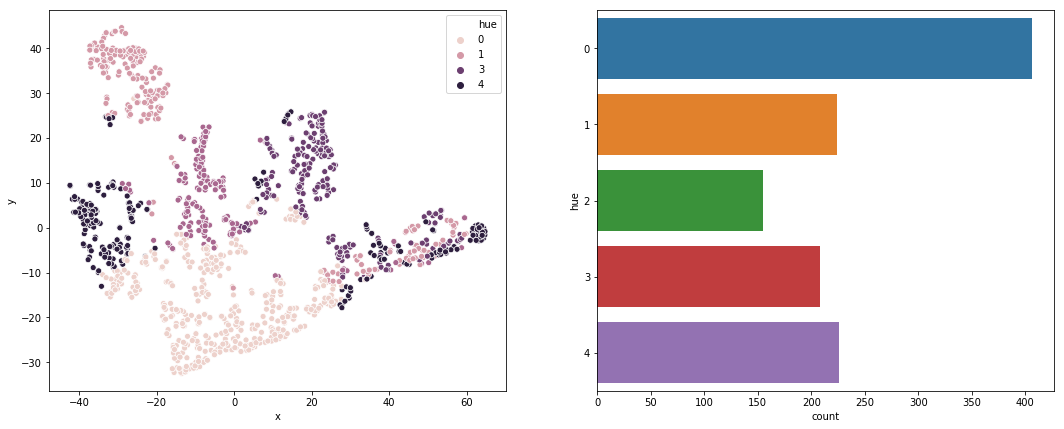

In [326]:
topic_map(nmf_cv, nmf)

In [329]:
def plot_top_term_weights(terms, H, topic_index, top ):
    # get the top terms and their weights
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    top_weights = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
        top_weights.append( H[topic_index,term_index] )
    # note we reverse the ordering for the plot
    top_terms.reverse()
    top_weights.reverse()
    # create the plot
    fig = plt.figure(figsize=(13,8))
    # add the horizontal bar chart
    ypos = np.arange(top)
    ax = plt.barh(ypos, top_weights, align="center", color="green",tick_label=top_terms)
    plt.xlabel("Term Weight",fontsize=14)
    plt.tight_layout()
    plt.show()

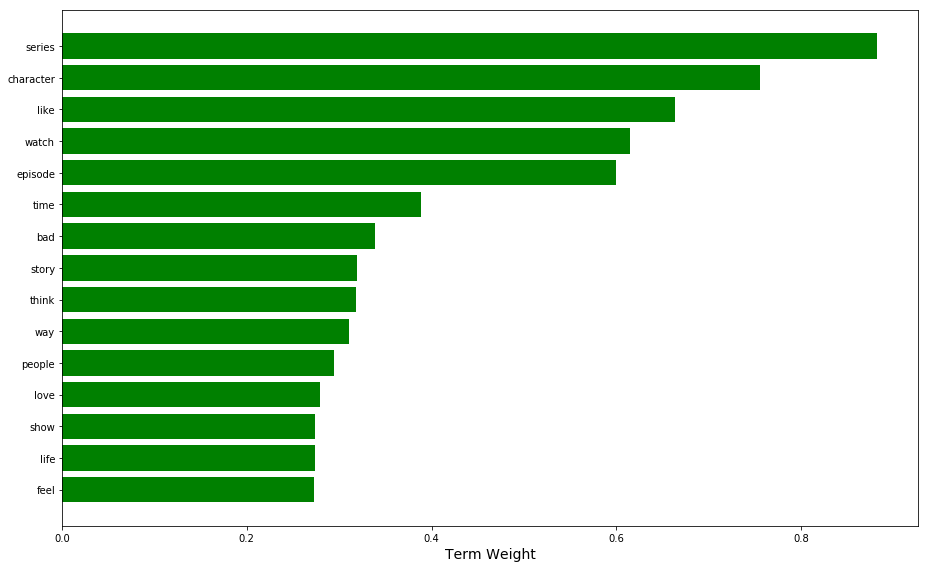

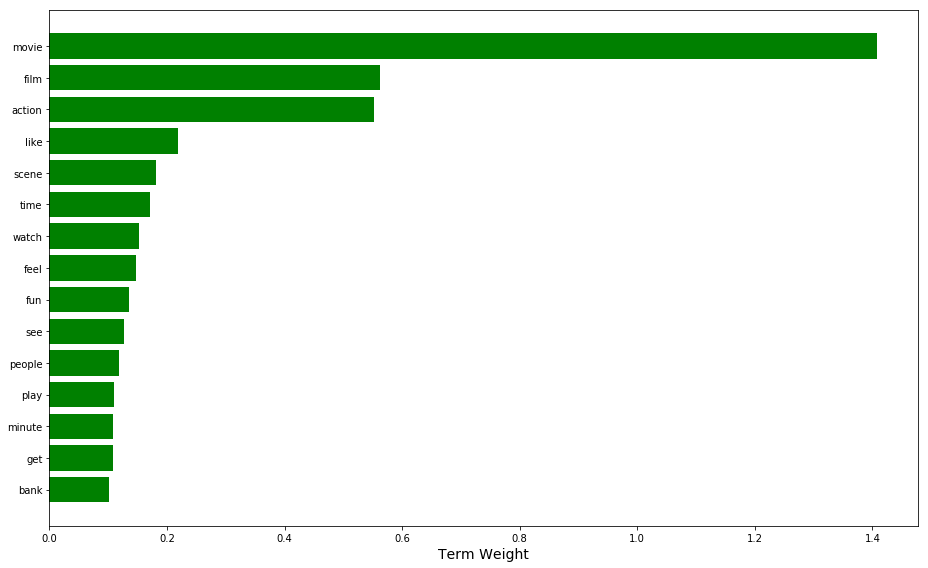

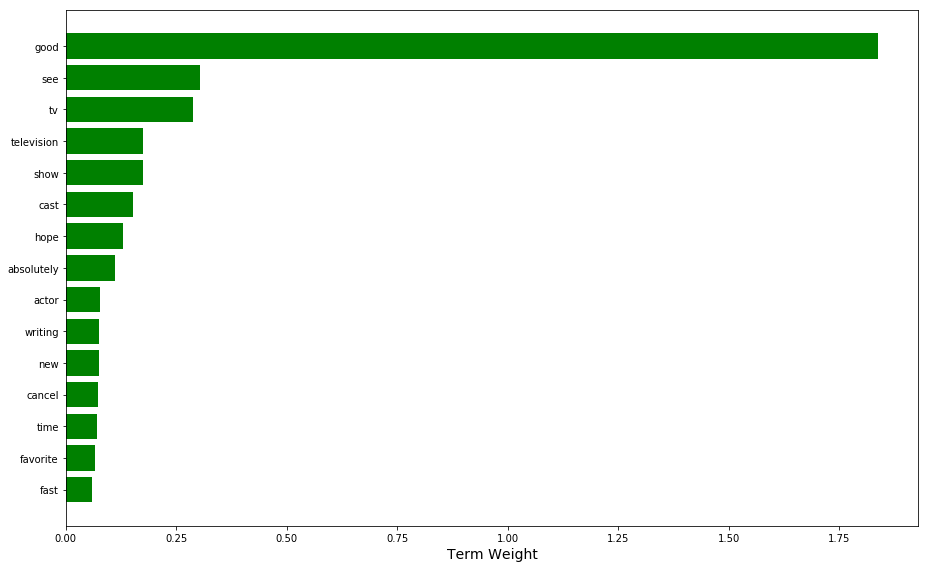

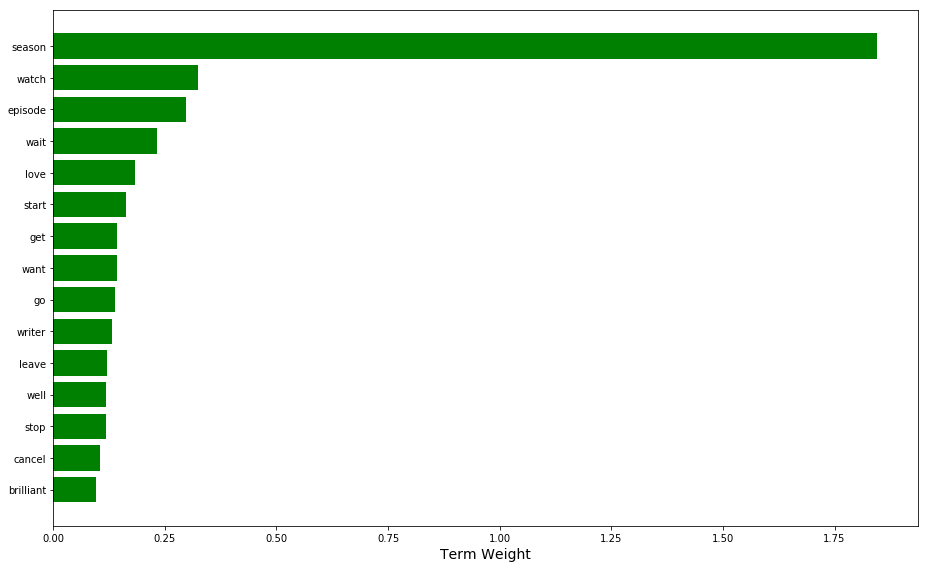

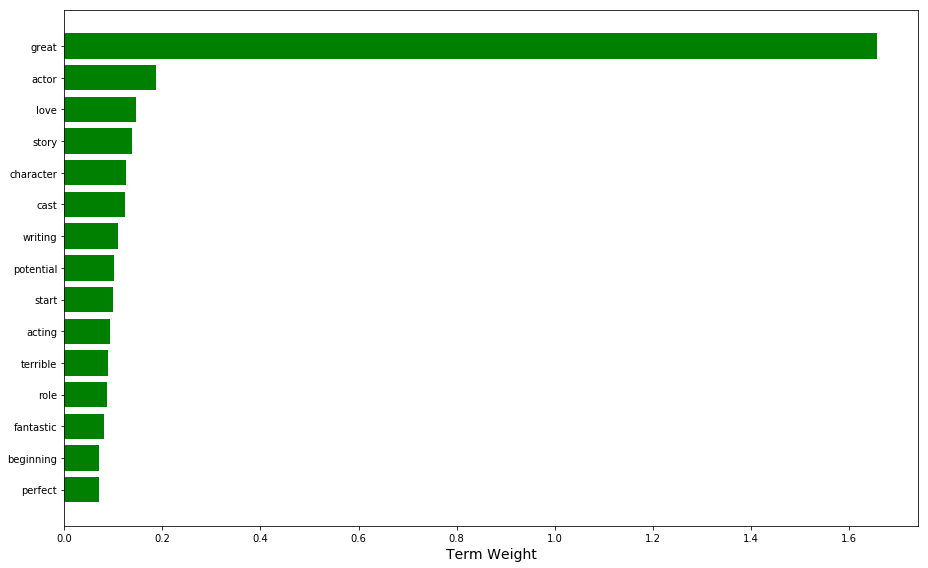

In [331]:
for t in range(n_components):
    plot_top_term_weights(cv_feature_names, nmf.components_, t, 15)

Upon initial look a few things pop out:

1) The NMF topics seem much more high level and it seems like there is some seperation between the topics, with some topics appearing better than other. While the LDA model is driven by very specific terms that are likely much less common, making it difficult to interpret. Perhaps increasing the cut-off for the words considered would help this out.